In [1]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#Optimization: Root-finding

In [2]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

Pkg.add("LinearAlgebra");
Pkg.add("PyPlot");
Pkg.add("ForwardDiff");

using LinearAlgebra;
using PyPlot;
#For differentiation of functions: gradient, jacobian, hessian
using ForwardDiff;

  Activating project at `~/Documents/Optimal_Control/Sims/Optimization`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Manifest.toml`


In [3]:
#CT State Space representation of Simple Pendulum
function Simple_Pendulum(x)
    l = 1.0
    g = 9.81
    
    θ = x[1]
    θ_dot = x[2]
    
    θ_doubledot = -(g/l)*sin(θ)
    
    return [θ_dot; θ_doubledot]
end

Simple_Pendulum (generic function with 1 method)

In [4]:
#Discretize with backward Euler
function backward_euler_step_fixed_point(fun, x0, h)
    xn = x0
    e = [norm(x0 + h.*fun(xn) - xn)]
    while e[end] > 1e-8
        xn = x0 + h.*fun(xn)
        e = [e; norm(x0 + h.*fun(xn) - xn)]
    end
    
    return xn, e
end

backward_euler_step_fixed_point (generic function with 1 method)

In [5]:
#Discretization using Backward Euler done using Newton's method
function backward_euler_step_newton(fun, x0, h)
    xn = x0
    #Compute residual
    r = x0 + h.*fun(xn) - xn
    e = [norm(r)]
    while e[end] > 1e-8 #tolerance
        δr = ForwardDiff.jacobian(x -> x0 + h.*fun(x) - x, xn)
        #Correct xn
        xn = xn - δr\r #inverse operation \
        #evaluate residual
        r = x0 + h.*fun(xn) - xn
        e = [e; norm(r)]
    end
    
    return xn, e
end

backward_euler_step_newton (generic function with 1 method)

In [6]:
function backward_euler_fixed_point(fun, x0, Tf, h)
    t = Array(0:h:Tf)
    
    x_hist = zeros(length(x0), length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1], e = backward_euler_step_fixed_point(fun, x_hist[:,k], h)
    end
    
    return x_hist, t
end

backward_euler_fixed_point (generic function with 1 method)

In [7]:
function backward_euler_newton(fun, x0, Tf, h)
    t = Array(0:h:Tf)
    x_hist = zeros(length(x0), length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1], e = backward_euler_step_newton(fun, x_hist[:,k], h)
    end
    
    return x_hist, t
end

backward_euler_newton (generic function with 1 method)

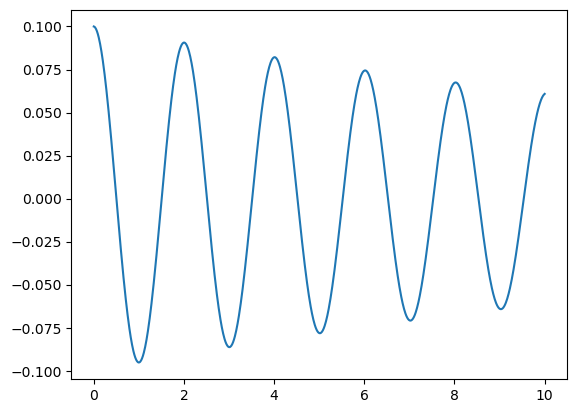

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f12307f0e80>

In [8]:
x0 = [.1; 0]
x_hist1, t_hist1 = backward_euler_fixed_point(Simple_Pendulum, x0, 10, 0.01)
x_hist2, t_hist2 = backward_euler_newton(Simple_Pendulum, x0, 10, 0.01)
length(t_hist2)
plot(t_hist1, x_hist1[1,:])
#plot(t_hist2, x_hist2[1,:])

In [10]:
max(abs.(x_hist1 - x_hist2)...)

7.3007510554383426e-6

In [12]:
xn, e1 = backward_euler_step_fixed_point(Simple_Pendulum, x0, 0.1)
e1
#took 14 iterations to find the root within 1e-8

14-element Vector{Float64}:
 0.09793658173053843
 0.009793658173053846
 0.009564124766684667
 0.0009564124766684723
 0.0009343853483241293
 9.343853483241571e-5
 9.128296581455142e-5
 9.128296581450979e-6
 8.917746787032166e-6
 8.917746786990532e-7
 8.712050176828967e-7
 8.712050177106523e-8
 8.511098474606182e-8
 8.511098478769519e-9

In [13]:
xn, e2 = backward_euler_step_newton(Simple_Pendulum, x0, 0.1)
e2
#took 3 iterations to find the root within 1e-8

3-element Vector{Float64}:
 0.09793658173053843
 3.7830087232931797e-6
 5.2874553670659e-15

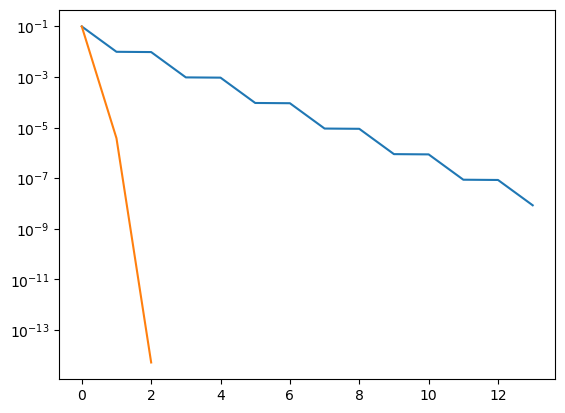

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f12306c3a30>

In [14]:
#fixed-point iteration has a linear convergence
semilogy(e1)
#Quadratic convergence: precision of result doubles in term of digits
semilogy(e2)